In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import torch
from torchinterp1d import Interp1d
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_train = pd.read_csv("dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("dataset/pointcloud_mnist_2d/test.csv")

In [3]:
X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()
X = X.reshape(X.shape[0], -1, 3)

In [4]:
sample_dataset = []
for i in range(X.shape[0]):
    sample = X[i, :, :]
    sample = sample[sample[:, 2] > 0][:, :2]
    sample_dataset.append(sample)

In [5]:
class FSpool():
      def __init__(self,ref):
          self.M,self.dim = ref.shape
          self.ref = ref       
          self.theta = self.generate_theta(self.dim)   
          self.sliced_ref = self.slicer(self.ref)
          self.sliced_ref_sorted, self.sliced_ref_sort_ind = torch.sort(self.sliced_ref,0)
          self.sliced_ref_cdf = torch.cumsum(torch.ones_like(self.sliced_ref),0)/self.M

      def generate_theta(self, d):

          return torch.eye(d)

      def slicer(self, X):
            #g_\theta(x)=\theta^T*x
            if len(self.theta.shape)==1:
                return torch.matmul(X,self.theta)
            else:
                return torch.matmul(X,self.theta.T)

      def embedd(self,x):
          N,d=x.shape
          assert d==self.dim
          sliced_data=self.slicer(x)
          sliced_data_sorted, sliced_data_index = torch.sort(sliced_data, dim=0)
          sliced_data_cdf = torch.cumsum(torch.ones_like(sliced_data),0)/N
          mongeMap = Interp1d()(sliced_data_cdf.T, sliced_data_sorted.T,
                                self.sliced_ref_cdf.T).T
          for l in range(2):
            mongeMap[self.sliced_ref_sort_ind[:,l],l]=torch.clone(mongeMap[:,l])

          embedd=(mongeMap-self.sliced_ref)/self.M
          return embedd

In [6]:
point_cloud = np.concatenate(sample_dataset, axis=0)

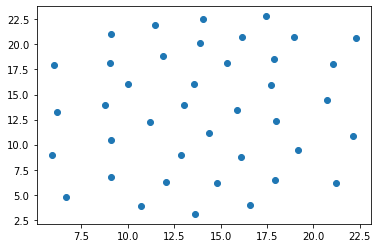

In [7]:
from sklearn.cluster import KMeans
ind=np.random.permutation(point_cloud.shape[0])[:10000]
kmeans = KMeans(n_clusters=40, random_state=0).fit(point_cloud[ind])
ref = torch.FloatTensor(kmeans.cluster_centers_)
plt.scatter(ref[:,0],ref[:,1])

In [8]:
sample_dataset = [torch.from_numpy(sample).to(torch.float) for sample in sample_dataset]

In [9]:
from tqdm.notebook import tqdm

In [10]:
phi = []
fs=FSpool(ref)
for sample in tqdm(sample_dataset):
    v = fs.embedd(sample)
    phi.append(v)
    
phi = torch.stack(phi, dim=0)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [11]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(phi.reshape(phi.shape[0],-1), y)

KNeighborsClassifier(n_neighbors=10)

In [12]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], -1, 3)
X_test = torch.from_numpy(X_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)
test_dataset = []
for i in range(X_test.shape[0]):
    test = X_test[i, :, :]
    test = test[test[:, 2] > 0][:, :2]
    test_dataset.append(test)

In [13]:
psi = []
for test in tqdm(test_dataset):
    w = fs.embedd(test)
    psi.append(w)
psi = torch.stack(psi, dim=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
preds = neigh.predict(psi.reshape(psi.shape[0],-1))
accuracy_score(preds,y_test)

0.8446